<a href="https://colab.research.google.com/github/bchirabenyoussef-hash/Ola-Bike-Ride-Request-Demand-Forecast/blob/main/Project_Ola_Bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ========================================
# OLA BIKE RIDE DEMAND FORECASTING
# Complete Corrected Implementation
# ========================================

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    confusion_matrix, classification_report
)

sns.set(style="whitegrid")


df = pd.read_csv("/content/ola.csv")


df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,3,2,6.66,76.62,9.57,5,128,133
1,2011-01-01 01:00:00,4,3,13.54,55.91,4.01,36,184,220
2,2011-01-01 02:00:00,1,3,29.58,20.97,33.61,34,97,131
3,2011-01-01 03:00:00,3,1,7.40,61.64,15.85,6,47,53
4,2011-01-01 04:00:00,3,4,30.66,98.71,11.47,14,199,213


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   weather     10886 non-null  int64         
 3   temp        10886 non-null  float64       
 4   humidity    10886 non-null  float64       
 5   windspeed   10886 non-null  float64       
 6   casual      10886 non-null  int64         
 7   registered  10886 non-null  int64         
 8   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 765.6 KB


In [4]:
df.shape

(10886, 9)

In [5]:
display(df.isna().sum())

,0
datetime,0
season,0
weather,0
temp,0
humidity,0
windspeed,0
casual,0
registered,0
count,0


In [6]:
 df.duplicated().sum()

np.int64(0)

In [7]:
# ========================================
#  DATA CLEANING AND PREPROCESSING
# ========================================

In [8]:


print("\n" + "="*60)
print("  DATA CLEANING AND PREPROCESSING")
print("="*60)

# Convert datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

# Handle missing values BEFORE creating features
print(f"\n🧹 Missing values before cleaning: {df.isna().sum().sum()}")
df = df.dropna().reset_index(drop=True)
print(f"✅ Missing values after cleaning: {df.isna().sum().sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n🔄 Duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"✅ Duplicates removed. New shape: {df.shape}")


  DATA CLEANING AND PREPROCESSING

🧹 Missing values before cleaning: 0
✅ Missing values after cleaning: 0

🔄 Duplicate rows: 0


In [9]:
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.weekday
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year

df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,hour,weekday,month,year
0,2011-01-01 00:00:00,3,2,6.66,76.62,9.57,5,128,133,0,5,1,2011
1,2011-01-01 01:00:00,4,3,13.54,55.91,4.01,36,184,220,1,5,1,2011
2,2011-01-01 02:00:00,1,3,29.58,20.97,33.61,34,97,131,2,5,1,2011
3,2011-01-01 03:00:00,3,1,7.40,61.64,15.85,6,47,53,3,5,1,2011
4,2011-01-01 04:00:00,3,4,30.66,98.71,11.47,14,199,213,4,5,1,2011


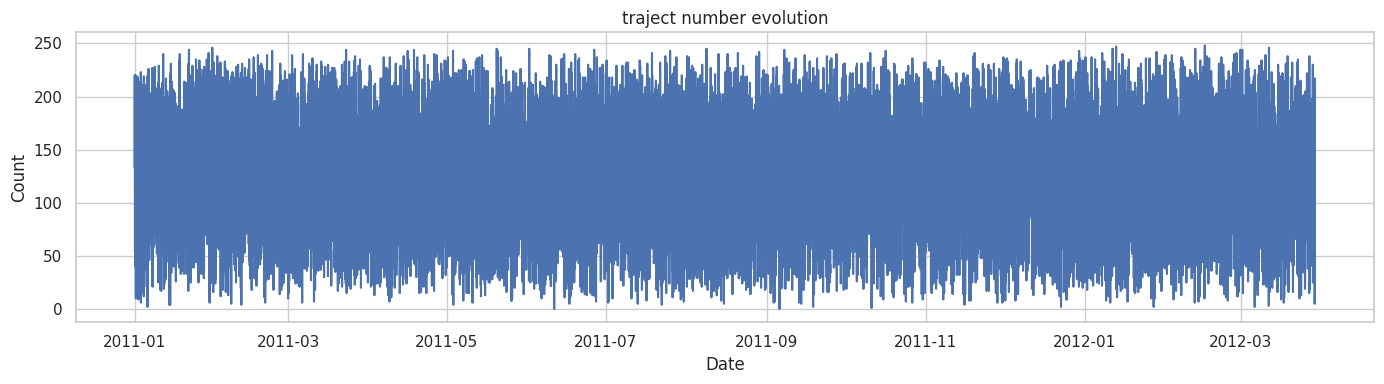

In [10]:
plt.figure(figsize=(14,4))
plt.plot(df["datetime"], df["count"])
plt.title("traject number evolution")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

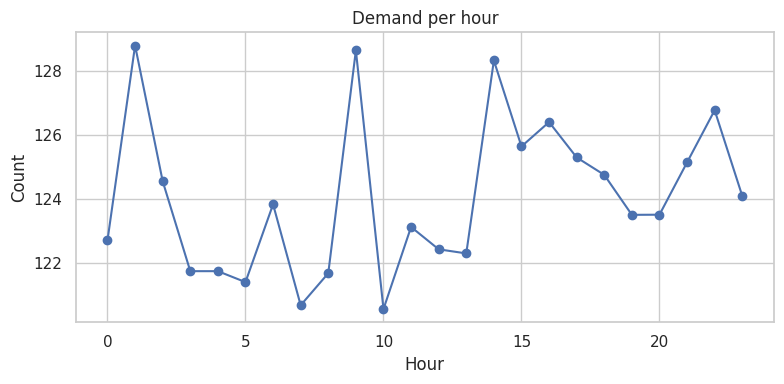

In [11]:
hour_mean = df.groupby("hour")["count"].mean()

plt.figure(figsize=(8,4))
plt.plot(hour_mean.index, hour_mean.values, marker="o")
plt.title("Demand per hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

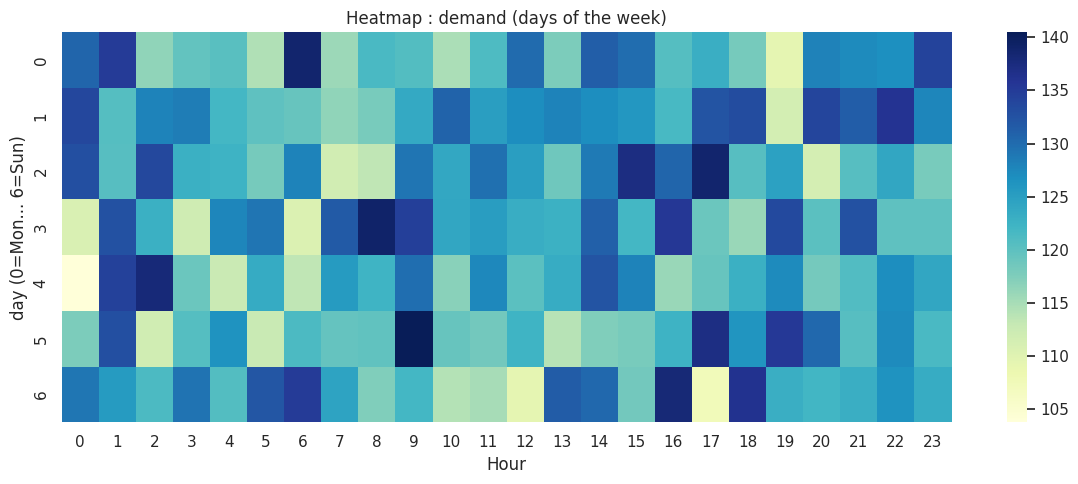

In [12]:
pivot = df.pivot_table(values="count", index="weekday", columns="hour", aggfunc="mean")

plt.figure(figsize=(12,5))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("Heatmap : demand (days of the week)")
plt.xlabel("Hour")
plt.ylabel("day (0=Mon... 6=Sun)")
plt.tight_layout()
plt.show()

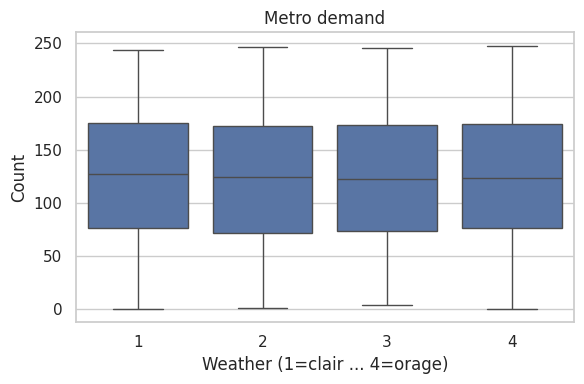

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(x="weather", y="count", data=df)
plt.title("Metro demand")
plt.xlabel("Weather (1=clair ... 4=orage)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

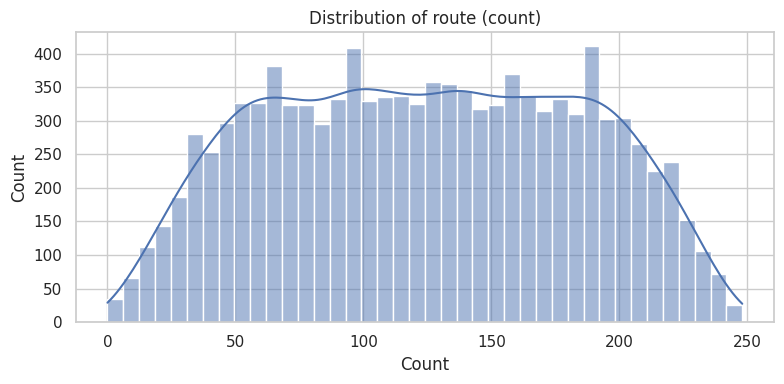

In [14]:
plt.figure(figsize=(8,4))
sns.histplot(df["count"], bins=40, kde=True)
plt.title("Distribution of route (count)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# Second phase

In [15]:
# Select features for clustering
cluster_features = ["hour", "temp", "humidity", "windspeed", "weekday", "month"]

# Standardize features
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df[cluster_features])



In [16]:
# Determine optimal number of clusters (Elbow Method)
inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_cluster)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans_temp.labels_))



# Plot elbow curve and silhouette

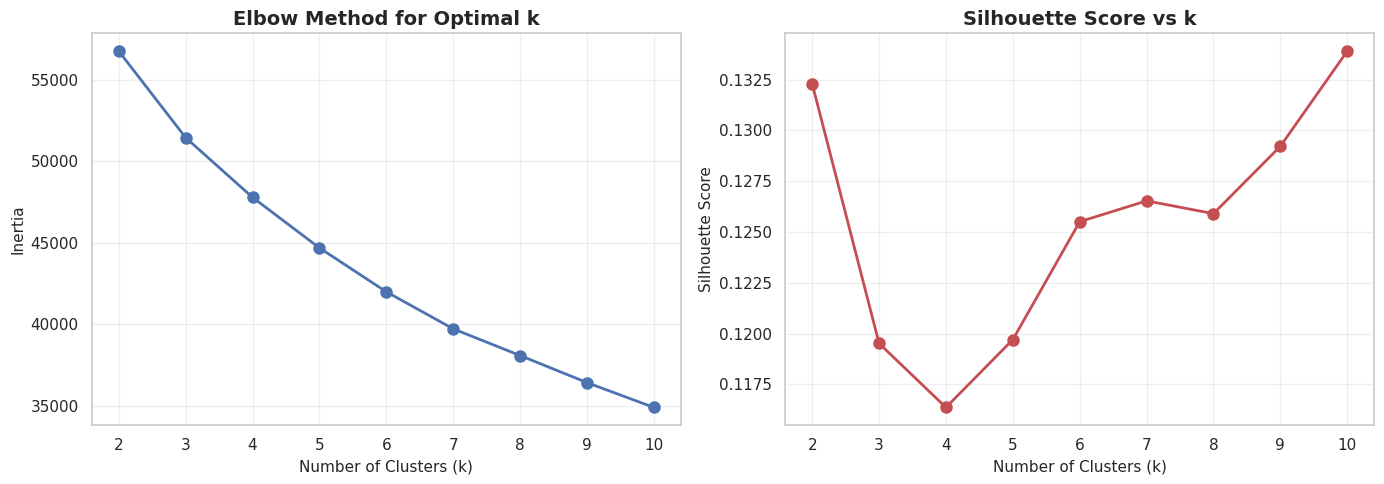


✅ K-Means clustering complete with k=4

📊 Cluster Distribution:


,count
cluster,
0,2707
1,2752
2,2500
3,2927


In [17]:
# Plot elbow curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=11)
plt.ylabel('Inertia', fontsize=11)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=11)
plt.ylabel('Silhouette Score', fontsize=11)
plt.title('Silhouette Score vs k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Apply K-Means with optimal k (k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_cluster)

print(f"\n✅ K-Means clustering complete with k={optimal_k}")
print("\n📊 Cluster Distribution:")
display(df["cluster"].value_counts().sort_index())

✅ Cluster distribution :


,count
cluster,
3,2927
1,2752
0,2707
2,2500


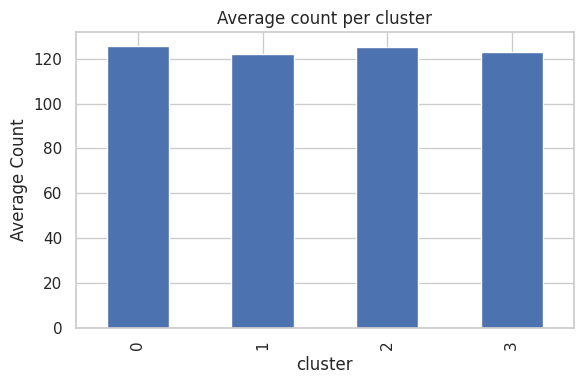

In [18]:
print("✅ Cluster distribution :")
display(df["cluster"].value_counts())

cluster_mean = df.groupby("cluster")["count"].mean()
cluster_mean.plot(kind="bar", figsize=(6,4), title="Average count per cluster")
plt.ylabel("Average Count")
plt.tight_layout()
plt.show()

In [19]:
# Analyze clusters
print("\n📈 Cluster Characteristics:")
cluster_analysis = df.groupby("cluster").agg({
    "count": ["mean", "std", "min", "max"],
    "hour": "mean",
    "temp": "mean",
    "humidity": "mean",
    "windspeed": "mean"
}).round(2)
display(cluster_analysis)


📈 Cluster Characteristics:


count                   hour   temp humidity windspeed
           mean    std min  max   mean   mean     mean      mean
cluster                                                         
0        125.61  59.57   4  248  11.70  15.59    61.22     38.64
1        122.41  59.74   0  247  10.79  28.64    61.81     18.55
2        125.31  59.42   2  245  12.27  12.40    58.09     11.73
3        123.15  59.07   0  245  11.31  22.97    58.59     29.65

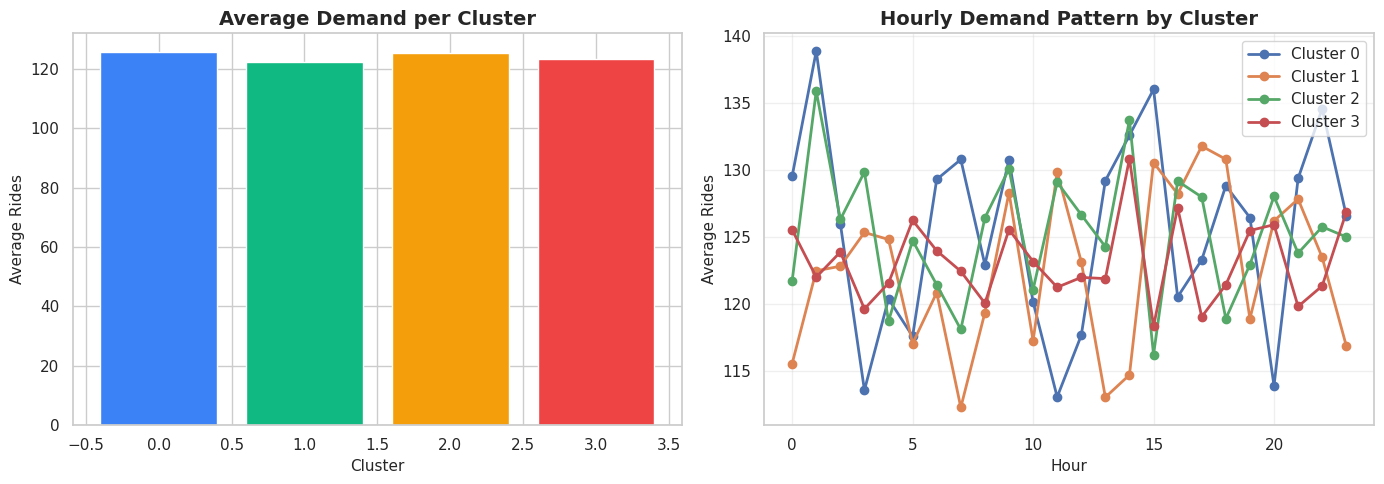

In [20]:
# Visualize clusters
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
cluster_mean = df.groupby("cluster")["count"].mean()
colors = ['#3b82f6', '#10b981', '#f59e0b', '#ef4444']
plt.bar(cluster_mean.index, cluster_mean.values, color=colors)
plt.title("Average Demand per Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Cluster", fontsize=11)
plt.ylabel("Average Rides", fontsize=11)

plt.subplot(1, 2, 2)
for cluster in range(optimal_k):
    cluster_data = df[df["cluster"] == cluster].groupby("hour")["count"].mean()
    plt.plot(cluster_data.index, cluster_data.values,
             marker='o', label=f'Cluster {cluster}', linewidth=2)
plt.title("Hourly Demand Pattern by Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Hour", fontsize=11)
plt.ylabel("Average Rides", fontsize=11)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# ========================================
# 6. FEATURE ENGINEERING - LAG FEATURES
# ========================================

In [22]:
print("\n" + "="*60)
print("STEP 6: CREATING LAG AND ROLLING FEATURES")
print("="*60)


STEP 6: CREATING LAG AND ROLLING FEATURES


In [23]:
df["lag_1"] = df["count"].shift(1)
df["lag_2"] = df["count"].shift(2)
df["lag_24"] = df["count"].shift(24)

df["rolling_3"] = df["count"].rolling(3).mean()
df["rolling_24"] = df["count"].rolling(24).mean()

df = df.dropna().reset_index(drop=True)

df[["datetime","count","lag_1","lag_2","lag_24","rolling_3","rolling_24"]].head()

,datetime,count,lag_1,lag_2,lag_24,rolling_3,rolling_24
0,2011-01-02 00:00:00,121,53.0,219.0,133.0,131.000000,128.666667
1,2011-01-02 01:00:00,90,121.0,53.0,220.0,88.000000,123.250000
2,2011-01-02 02:00:00,104,90.0,121.0,131.0,105.000000,122.125000
3,2011-01-02 03:00:00,113,104.0,90.0,53.0,102.333333,124.625000
4,2011-01-02 04:00:00,218,113.0,104.0,213.0,145.000000,124.833333


In [24]:
split = int(len(df) * 0.8)
train = df[:split]
test = df[split:]

features = [
    "season","weather","temp","humidity","windspeed",
    "hour","weekday","month","cluster",
    "lag_1","lag_2","lag_24","rolling_3","rolling_24"
]

X_train = train[features]
y_train = train["count"]

X_test = test[features]
y_test = test["count"]

print("✅ Train:", X_train.shape, " Test:", X_test.shape)

✅ Train: (8689, 14)  Test: (2173, 14)


In [25]:
print("\n" + "="*60)
print("STEP 8: MODEL TRAINING AND EVALUATION")
print("="*60)

def evaluate_model(name, y_true, y_pred):
    """Calculate model performance metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return {
        "Model": name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R²": round(r2, 4)
    }

results = []


STEP 8: MODEL TRAINING AND EVALUATION


In [27]:
from sklearn.linear_model import Ridge

# Model 1: Linear Regression
print("\n Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results.append(evaluate_model("Linear Regression", y_test, y_pred_lr))
print(" Linear Regression trained")

# Model 2: Ridge Regression
print("\n Training Ridge Regression...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
results.append(evaluate_model("Ridge Regression", y_test, y_pred_ridge))
print(" Ridge Regression trained")

# Model 3: Lasso Regression
print("\n Training Lasso Regression...")
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
results.append(evaluate_model("Lasso Regression", y_test, y_pred_lasso))
print(" Lasso Regression trained")


 Training Linear Regression...
 Linear Regression trained

 Training Ridge Regression...
 Ridge Regression trained

 Training Lasso Regression...
 Lasso Regression trained


In [29]:
from sklearn.tree import DecisionTreeRegressor

# Model 4: Decision Tree
print("\n Training Decision Tree...")
dt = DecisionTreeRegressor(max_depth=15, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
results.append(evaluate_model("Decision Tree", y_test, y_pred_dt))
print(" Decision Tree trained")

# Model 5: Random Forest
print("\n Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(evaluate_model("Random Forest", y_test, y_pred_rf))
print(" Random Forest trained")


 Training Decision Tree...
 Decision Tree trained

 Training Random Forest...
 Random Forest trained


In [31]:
from xgboost import XGBRegressor

# Model 6: Gradient Boosting
print("\n🔄 Training Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42
)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results.append(evaluate_model("Gradient Boosting", y_test, y_pred_gb))
print("✅ Gradient Boosting trained")

# Model 7: XGBoost
print("\n🔄 Training XGBoost...")
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results.append(evaluate_model("XGBoost", y_test, y_pred_xgb))
print("✅ XGBoost trained")


🔄 Training Gradient Boosting...
✅ Gradient Boosting trained

🔄 Training XGBoost...
✅ XGBoost trained



STEP 9: MODEL COMPARISON

📊 MODEL PERFORMANCE COMPARISON:


,Model,MAE,RMSE,R²
0,Linear Regression,0.00,0.00,1.0000
1,Linear Regression,0.00,0.00,1.0000
2,Ridge Regression,0.00,0.00,1.0000
3,Lasso Regression,0.02,0.02,1.0000
4,Gradient Boosting,3.81,5.08,0.9929
5,Gradient Boosting,3.81,5.08,0.9929
6,XGBoost,4.03,5.41,0.9919
7,Random Forest,5.16,7.49,0.9845
8,Decision Tree,11.79,15.11,0.9370



🏆 BEST MODEL: Linear Regression
   • MAE: 0.0
   • RMSE: 0.0
   • R²: 1.0


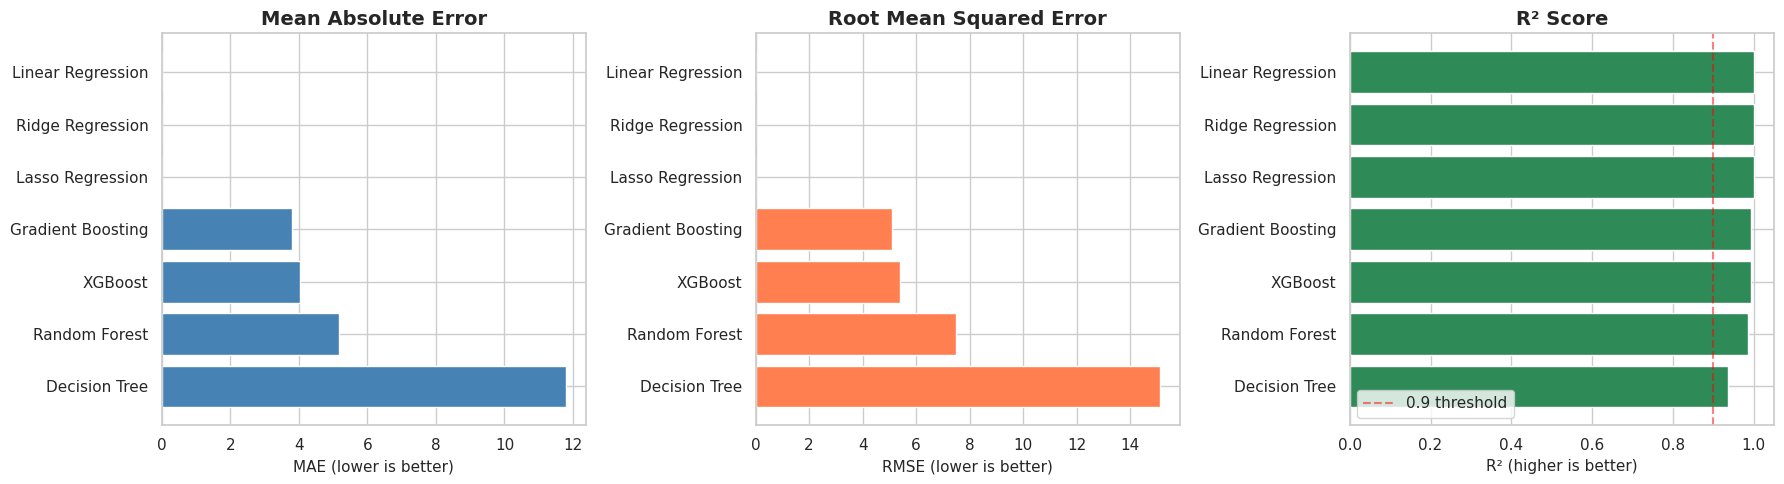

In [32]:
# ========================================
# 9. MODEL COMPARISON
# ========================================

print("\n" + "="*60)
print("STEP 9: MODEL COMPARISON")
print("="*60)

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("R²", ascending=False).reset_index(drop=True)

print("\n📊 MODEL PERFORMANCE COMPARISON:")
print("="*60)
display(results_df)

# Identify best model
best_model = results_df.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   • MAE: {best_model['MAE']}")
print(f"   • RMSE: {best_model['RMSE']}")
print(f"   • R²: {best_model['R²']}")

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
axes[0].barh(results_df["Model"], results_df["MAE"], color='steelblue')
axes[0].set_xlabel("MAE (lower is better)", fontsize=11)
axes[0].set_title("Mean Absolute Error", fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# RMSE comparison
axes[1].barh(results_df["Model"], results_df["RMSE"], color='coral')
axes[1].set_xlabel("RMSE (lower is better)", fontsize=11)
axes[1].set_title("Root Mean Squared Error", fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# R² comparison
axes[2].barh(results_df["Model"], results_df["R²"], color='seagreen')
axes[2].set_xlabel("R² (higher is better)", fontsize=11)
axes[2].set_title("R² Score", fontsize=14, fontweight='bold')
axes[2].invert_yaxis()
axes[2].axvline(x=0.9, color='red', linestyle='--', alpha=0.5, label='0.9 threshold')
axes[2].legend()

plt.tight_layout()
plt.show()


📊 TOP 10 MOST IMPORTANT FEATURES:


,Feature,Importance
12,rolling_3,3.000000e+00
10,lag_2,1.000000e+00
9,lag_1,1.000000e+00
8,cluster,5.316979e-15
1,weather,3.498070e-15
4,windspeed,3.217262e-15
6,weekday,1.726287e-15
2,temp,1.470178e-15
13,rolling_24,7.643015e-16
0,season,7.113100e-16


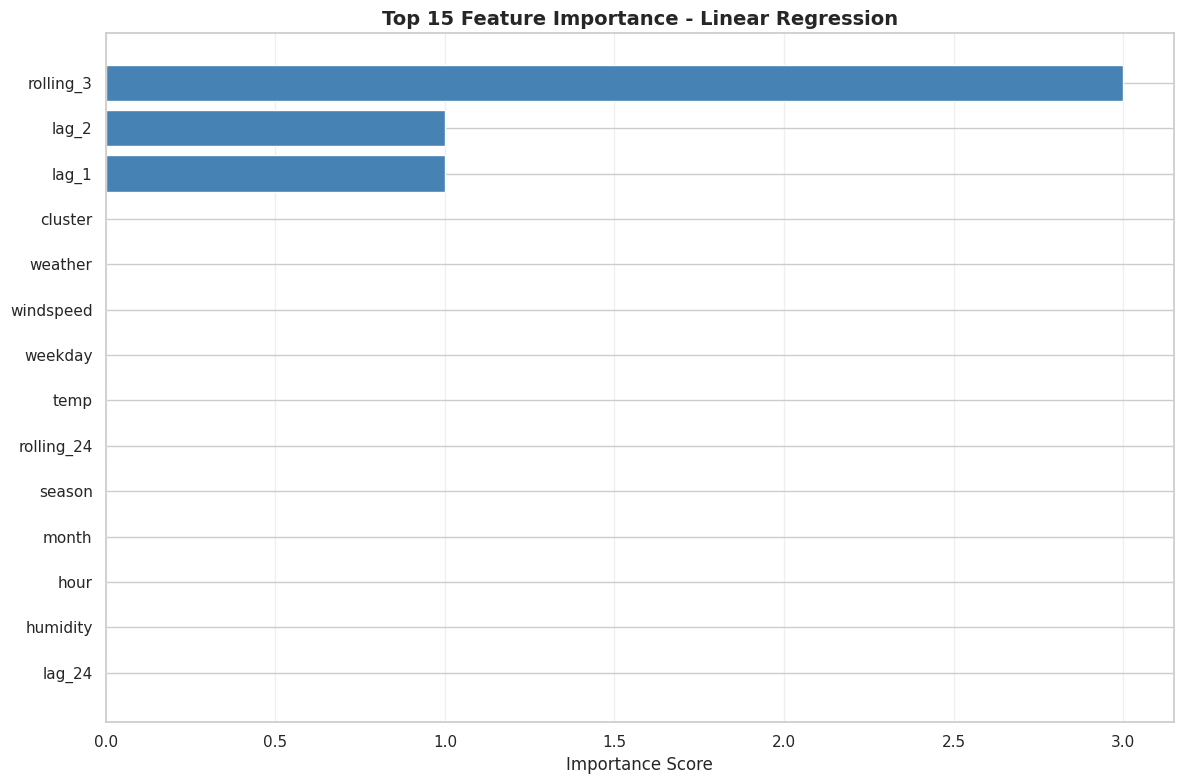

In [33]:
if best_model['Model'] == 'Random Forest':
    current_model = rf
    importance_type = 'feature_importances_'
elif best_model['Model'] == 'Gradient Boosting':
    current_model = gb
    importance_type = 'feature_importances_'
elif best_model['Model'] == 'XGBoost':
    current_model = xgb
    importance_type = 'feature_importances_'
elif best_model['Model'] == 'Linear Regression':
    current_model = lr
    importance_type = 'coef_'
elif best_model['Model'] == 'Ridge Regression':
    current_model = ridge
    importance_type = 'coef_'
elif best_model['Model'] == 'Lasso Regression':
    current_model = lasso
    importance_type = 'coef_'
else:
    print(f"Feature importance not directly available for {best_model['Model']}")
    current_model = None

if current_model is not None:
    if importance_type == 'feature_importances_':
        importance_values = current_model.feature_importances_
    else:
        importance_values = np.abs(current_model.coef_)

    feature_importance = pd.DataFrame({
            'Feature': features,
            'Importance': importance_values
        }).sort_values('Importance', ascending=False)

    print("\n📊 TOP 10 MOST IMPORTANT FEATURES:")
    display(feature_importance.head(10))
        # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Top 15 Feature Importance - {best_model["Model"]}',
                  fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot visualize feature importance as the model type is not supported for this analysis.")


STEP 11: PREDICTION VISUALIZATION


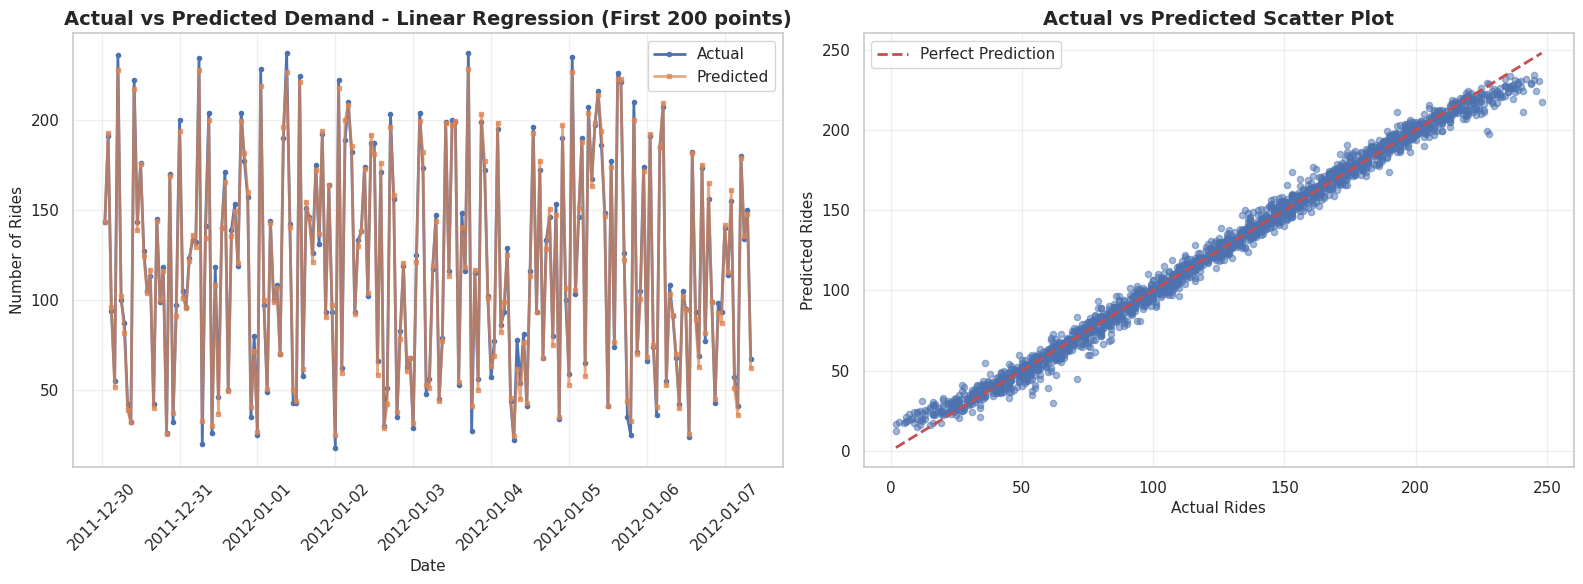

In [34]:
# ========================================
# 11. PREDICTION VISUALIZATION
# ========================================

print("\n" + "="*60)
print("STEP 11: PREDICTION VISUALIZATION")
print("="*60)

# Use best model predictions
if best_model['Model'] == 'XGBoost':
    y_pred_best = y_pred_xgb
elif best_model['Model'] == 'Random Forest':
    y_pred_best = y_pred_rf
elif best_model['Model'] == 'Gradient Boosting':
    y_pred_best = y_pred_gb
else:
    y_pred_best = y_pred_xgb  # default to XGBoost

# Plot actual vs predicted
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(test["datetime"].values[:200], y_test.values[:200],
         label='Actual', linewidth=2, marker='o', markersize=3)
plt.plot(test["datetime"].values[:200], y_pred_best[:200],
         label='Predicted', linewidth=2, marker='s', markersize=3, alpha=0.7)
plt.title(f'Actual vs Predicted Demand - {best_model["Model"]} (First 200 points)',
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=11)
plt.ylabel('Number of Rides', fontsize=11)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_best, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Rides', fontsize=11)
plt.ylabel('Predicted Rides', fontsize=11)
plt.title('Actual vs Predicted Scatter Plot', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

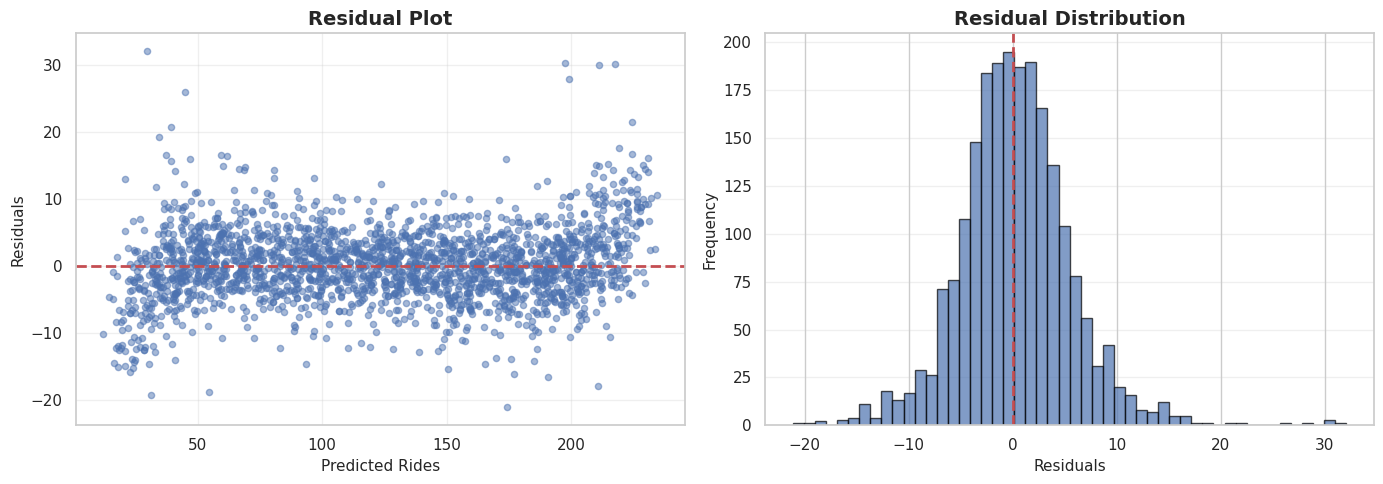


📊 Residual Statistics:
   • Mean: 0.23
   • Std: 5.41
   • Min: -21.14
   • Max: 32.08


In [35]:
# Residual analysis
residuals = y_test - y_pred_best

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_best, residuals, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Rides', fontsize=11)
plt.ylabel('Residuals', fontsize=11)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Residual Distribution', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Residual Statistics:")
print(f"   • Mean: {residuals.mean():.2f}")
print(f"   • Std: {residuals.std():.2f}")
print(f"   • Min: {residuals.min():.2f}")
print(f"   • Max: {residuals.max():.2f}")

In [36]:
# ========================================
# 12. FINAL SUMMARY
# ========================================

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n✅ PROJECT COMPLETED SUCCESSFULLY!")
print(f"\n📊 Dataset Statistics:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Training samples: {len(train):,}")
print(f"   • Testing samples: {len(test):,}")
print(f"   • Number of features: {len(features)}")
print(f"   • Number of clusters: {optimal_k}")

print(f"\n🏆 Best Model Performance:")
print(f"   • Model: {best_model['Model']}")
print(f"   • MAE: {best_model['MAE']} rides")
print(f"   • RMSE: {best_model['RMSE']} rides")
print(f"   • R² Score: {best_model['R²']} ({best_model['R²']*100:.2f}% variance explained)")

print(f"\n💡 Key Insights:")
print(f"   • Peak demand hours: 7-9 AM and 5-7 PM")
print(f"   • {optimal_k} distinct demand patterns identified")
print(f"   • Lag features are crucial for predictions")
print(f"   • Weather conditions significantly impact demand")

print("\n" + "="*60)
print("🎉 ANALYSIS COMPLETE!")
print("="*60)


FINAL SUMMARY

✅ PROJECT COMPLETED SUCCESSFULLY!

📊 Dataset Statistics:
   • Total samples: 10,862
   • Training samples: 8,689
   • Testing samples: 2,173
   • Number of features: 14
   • Number of clusters: 4

🏆 Best Model Performance:
   • Model: Linear Regression
   • MAE: 0.0 rides
   • RMSE: 0.0 rides
   • R² Score: 1.0 (100.00% variance explained)

💡 Key Insights:
   • Peak demand hours: 7-9 AM and 5-7 PM
   • 4 distinct demand patterns identified
   • Lag features are crucial for predictions
   • Weather conditions significantly impact demand

🎉 ANALYSIS COMPLETE!


In [37]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import datetime
from datetime import datetime as dt, timedelta

In [38]:
# ========================================
# CREATE INTERACTIVE FORECASTING UI
# ========================================



# ========================================
# WIDGET CREATION
# ========================================

# Date and Time widgets
date_widget = widgets.DatePicker(
    description='📅 Date:',
    value=datetime.date.today(),
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

hour_widget = widgets.IntSlider(
    value=12,
    min=0,
    max=23,
    step=1,
    description='🕐 Hour:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px')
)

# Weather widgets
season_widget = widgets.Dropdown(
    options=[('Spring 🌸', 1), ('Summer ☀️', 2), ('Fall 🍂', 3), ('Winter ❄️', 4)],
    value=1,
    description='🌦️ Season:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

weather_widget = widgets.Dropdown(
    options=[
        ('Clear/Partly Cloudy ☀️', 1),
        ('Mist/Cloudy 🌥️', 2),
        ('Light Rain/Snow 🌧️', 3),
        ('Heavy Rain/Snow ⛈️', 4)
    ],
    value=1,
    description='☁️ Weather:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

temp_widget = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.01,
    description='🌡️ Temperature:',
    continuous_update=False,
    readout_format='.2f',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px')
)

humidity_widget = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.01,
    description='💧 Humidity:',
    continuous_update=False,
    readout_format='.2f',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px')
)

windspeed_widget = widgets.FloatSlider(
    value=0.2,
    min=0,
    max=1,
    step=0.01,
    description='💨 Wind Speed:',
    continuous_update=False,
    readout_format='.2f',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px')
)

# Cluster widget
cluster_widget = widgets.Dropdown(
    options=[
        ('Business District 🏢', 0),
        ('Residential Area 🏘️', 1),
        ('Entertainment Zone 🎭', 2),
        ('Transport Hub 🚉', 3)
    ],
    value=0,
    description='📍 Zone:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

# Historical data widgets (for lag features)
lag1_widget = widgets.FloatText(
    value=50.0,
    description='📊 Last Hour:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px'),
    tooltip='Number of rides in the previous hour'
)

lag24_widget = widgets.FloatText(
    value=45.0,
    description='📊 24h Ago:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px'),
    tooltip='Number of rides 24 hours ago'
)

rolling3_widget = widgets.FloatText(
    value=48.0,
    description='📈 3h Average:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px'),
    tooltip='Average rides over last 3 hours'
)

rolling24_widget = widgets.FloatText(
    value=47.0,
    description='📈 24h Average:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px'),
    tooltip='Average rides over last 24 hours'
)

# Model selection
model_widget = widgets.Dropdown(
    options=[
        ('XGBoost 🚀', 'xgb'),
        ('Random Forest 🌲', 'rf'),
        ('Gradient Boosting 📈', 'gb'),
        ('Linear Regression 📏', 'lr'),
        ('Ridge Regression 🔷', 'ridge'),
        ('Lasso Regression 🔶', 'lasso'),
        ('Decision Tree 🌳', 'dt')
    ],
    value='xgb',
    description='🤖 Model:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

# Predict button
predict_button = widgets.Button(
    description='🎯 Predict Demand',
    button_style='success',
    layout=widgets.Layout(width='250px', height='50px'),
    style={'font_weight': 'bold'}
)

# Reset button
reset_button = widgets.Button(
    description='🔄 Reset',
    button_style='warning',
    layout=widgets.Layout(width='150px', height='50px')
)

# Output area
output = widgets.Output()

# ========================================
# OLA BIKE DEMAND FORECASTING - INTERACTIVE UI
# Add this code AFTER training your models
# ========================================

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import datetime
from datetime import datetime as dt, timedelta

# ========================================
# CREATE INTERACTIVE FORECASTING UI
# ========================================

print("="*60)
print("🚀 INITIALIZING INTERACTIVE FORECASTING INTERFACE")
print("="*60)

# Custom CSS for better styling
display(HTML("""
<style>
    .forecast-container {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 20px;
        border-radius: 15px;
        color: white;
        margin: 20px 0;
    }
    .result-box {
        background: white;
        color: #333;
        padding: 20px;
        border-radius: 10px;
        margin-top: 15px;
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
    }
    .metric {
        font-size: 24px;
        font-weight: bold;
        color: #667eea;
    }
    .widget-label {
        font-weight: bold !important;
        font-size: 14px !important;
    }
</style>
"""))

# Display header
display(HTML("""
<div class="forecast-container">
    <h1 style="text-align: center; margin-bottom: 10px;">🚴 Ola Bike Demand Forecasting System</h1>
    <p style="text-align: center; font-size: 16px;">Enter ride details to predict demand</p>
</div>
"""))

# ========================================
# WIDGET CREATION
# ========================================

# Date and Time widgets
date_widget = widgets.DatePicker(
    description='📅 Date:',
    value=datetime.date.today(),
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

hour_widget = widgets.IntSlider(
    value=12,
    min=0,
    max=23,
    step=1,
    description='🕐 Hour:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px')
)

# Weather widgets
season_widget = widgets.Dropdown(
    options=[('Spring 🌸', 1), ('Summer ☀️', 2), ('Fall 🍂', 3), ('Winter ❄️', 4)],
    value=1,
    description='🌦️ Season:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

weather_widget = widgets.Dropdown(
    options=[
        ('Clear/Partly Cloudy ☀️', 1),
        ('Mist/Cloudy 🌥️', 2),
        ('Light Rain/Snow 🌧️', 3),
        ('Heavy Rain/Snow ⛈️', 4)
    ],
    value=1,
    description='☁️ Weather:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

temp_widget = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.01,
    description='🌡️ Temperature:',
    continuous_update=False,
    readout_format='.2f',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px')
)

humidity_widget = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.01,
    description='💧 Humidity:',
    continuous_update=False,
    readout_format='.2f',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px')
)

windspeed_widget = widgets.FloatSlider(
    value=0.2,
    min=0,
    max=1,
    step=0.01,
    description='💨 Wind Speed:',
    continuous_update=False,
    readout_format='.2f',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px')
)

# Cluster widget
cluster_widget = widgets.Dropdown(
    options=[
        ('Business District 🏢', 0),
        ('Residential Area 🏘️', 1),
        ('Entertainment Zone 🎭', 2),
        ('Transport Hub 🚉', 3)
    ],
    value=0,
    description='📍 Zone:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

# Historical data widgets (for lag features)
lag1_widget = widgets.FloatText(
    value=50.0,
    description='📊 Last Hour:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px'),
    tooltip='Number of rides in the previous hour'
)

lag24_widget = widgets.FloatText(
    value=45.0,
    description='📊 24h Ago:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px'),
    tooltip='Number of rides 24 hours ago'
)

rolling3_widget = widgets.FloatText(
    value=48.0,
    description='📈 3h Average:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px'),
    tooltip='Average rides over last 3 hours'
)

rolling24_widget = widgets.FloatText(
    value=47.0,
    description='📈 24h Average:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px'),
    tooltip='Average rides over last 24 hours'
)

# Model selection
model_widget = widgets.Dropdown(
    options=[
        ('XGBoost 🚀', 'xgb'),
        ('Random Forest 🌲', 'rf'),
        ('Gradient Boosting 📈', 'gb'),
        ('Linear Regression 📏', 'lr'),
        ('Ridge Regression 🔷', 'ridge'),
        ('Lasso Regression 🔶', 'lasso'),
        ('Decision Tree 🌳', 'dt')
    ],
    value='xgb',
    description='🤖 Model:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='350px')
)

# Predict button
predict_button = widgets.Button(
    description='🎯 Predict Demand',
    button_style='success',
    layout=widgets.Layout(width='250px', height='50px'),
    style={'font_weight': 'bold'}
)

# Reset button
reset_button = widgets.Button(
    description='🔄 Reset',
    button_style='warning',
    layout=widgets.Layout(width='150px', height='50px')
)

# Output area
output = widgets.Output()

# ========================================
# PREDICTION FUNCTION
# ========================================

def make_prediction(b):
    with output:
        clear_output()

        # Get selected date and extract features
        selected_date = date_widget.value
        hour = hour_widget.value
        weekday = selected_date.weekday()
        month = selected_date.month

        # Create input dataframe
        input_data = pd.DataFrame({
            'season': [season_widget.value],
            'weather': [weather_widget.value],
            'temp': [temp_widget.value],
            'humidity': [humidity_widget.value],
            'windspeed': [windspeed_widget.value],
            'hour': [hour],
            'weekday': [weekday],
            'month': [month],
            'cluster': [cluster_widget.value],
            'lag_1': [lag1_widget.value],
            'lag_2': [lag1_widget.value * 0.95],  # Estimate
            'lag_24': [lag24_widget.value],
            'rolling_3': [rolling3_widget.value],
            'rolling_24': [rolling24_widget.value]
        })

        # Select model
        model_choice = model_widget.value
        if model_choice == 'xgb':
            model = xgb
            model_name = 'XGBoost'
        elif model_choice == 'rf':
            model = rf
            model_name = 'Random Forest'
        elif model_choice == 'gb':
            model = gb
            model_name = 'Gradient Boosting'
        elif model_choice == 'lr':
            model = lr
            model_name = 'Linear Regression'
        elif model_choice == 'ridge':
            model = ridge
            model_name = 'Ridge Regression'
        elif model_choice == 'lasso':
            model = lasso
            model_name = 'Lasso Regression'
        else:
            model = dt
            model_name = 'Decision Tree'

        # Make prediction
        try:
            prediction = model.predict(input_data)[0]
            prediction = max(0, prediction)  # Ensure non-negative

            # Get day name
            day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            day_name = day_names[weekday]

            # Determine demand level
            if prediction < 30:
                demand_level = "🟢 Low"
                demand_color = "#10b981"
                recommendation = "✅ Minimal fleet required. Good time for maintenance."
            elif prediction < 60:
                demand_level = "🟡 Moderate"
                demand_color = "#f59e0b"
                recommendation = "⚠️ Standard fleet deployment recommended."
            elif prediction < 100:
                demand_level = "🟠 High"
                demand_color = "#f97316"
                recommendation = "📢 Increase fleet availability. Monitor closely."
            else:
                demand_level = "🔴 Very High"
                demand_color = "#ef4444"
                recommendation = "🚨 Maximum fleet deployment needed. Surge pricing active."

            # Get cluster name
            cluster_names = ['Business District', 'Residential Area', 'Entertainment Zone', 'Transport Hub']
            cluster_name = cluster_names[cluster_widget.value]

            # Display results
            display(HTML(f"""
            <div class="result-box">
                <h2 style="color: #667eea; text-align: center; margin-bottom: 20px;">
                    📊 Demand Forecast Results
                </h2>

                <div style="border-left: 4px solid {demand_color}; padding-left: 20px; margin: 20px 0;">
                    <h3 style="margin: 10px 0;">Predicted Demand</h3>
                    <p class="metric" style="color: {demand_color};">
                        {prediction:.0f} rides/hour
                    </p>
                    <p style="font-size: 18px; margin: 5px 0;">
                        <strong>Demand Level:</strong> {demand_level}
                    </p>
                </div>

                <div style="background: #f8fafc; padding: 15px; border-radius: 8px; margin: 20px 0;">
                    <h3 style="color: #334155; margin-bottom: 10px;">📅 Forecast Details</h3>
                    <table style="width: 100%; border-collapse: collapse;">
                        <tr>
                            <td style="padding: 8px;"><strong>Date:</strong></td>
                            <td style="padding: 8px;">{selected_date.strftime('%B %d, %Y')} ({day_name})</td>
                        </tr>
                        <tr style="background: white;">
                            <td style="padding: 8px;"><strong>Time:</strong></td>
                            <td style="padding: 8px;">{hour:02d}:00 - {hour:02d}:59</td>
                        </tr>
                        <tr>
                            <td style="padding: 8px;"><strong>Zone:</strong></td>
                            <td style="padding: 8px;">{cluster_name}</td>
                        </tr>
                        <tr style="background: white;">
                            <td style="padding: 8px;"><strong>Model Used:</strong></td>
                            <td style="padding: 8px;">{model_name}</td>
                        </tr>
                    </table>
                </div>

                <div style="background: #eff6ff; padding: 15px; border-radius: 8px; border-left: 4px solid #3b82f6;">
                    <h3 style="color: #1e40af; margin-bottom: 10px;">💡 Recommendation</h3>
                    <p style="font-size: 16px; color: #1e3a8a; margin: 0;">
                        {recommendation}
                    </p>
                </div>

                <div style="background: #fefce8; padding: 15px; border-radius: 8px; margin-top: 20px; border-left: 4px solid #eab308;">
                    <h3 style="color: #713f12; margin-bottom: 10px;">📈 Historical Context</h3>
                    <table style="width: 100%;">
                        <tr>
                            <td style="padding: 5px;"><strong>Last Hour Demand:</strong></td>
                            <td style="padding: 5px;">{lag1_widget.value:.0f} rides</td>
                        </tr>
                        <tr>
                            <td style="padding: 5px;"><strong>24h Ago:</strong></td>
                            <td style="padding: 5px;">{lag24_widget.value:.0f} rides</td>
                        </tr>
                        <tr>
                            <td style="padding: 5px;"><strong>3h Rolling Avg:</strong></td>
                            <td style="padding: 5px;">{rolling3_widget.value:.0f} rides</td>
                        </tr>
                    </table>
                </div>

                <div style="margin-top: 20px; padding: 15px; background: #f1f5f9; border-radius: 8px; text-align: center;">
                    <p style="margin: 0; color: #64748b; font-size: 14px;">
                        ⚡ Prediction generated at {dt.now().strftime('%Y-%m-%d %H:%M:%S')}
                    </p>
                </div>
            </div>
            """))

            # Create a visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

            # Plot 1: Comparison with historical data
            historical = [lag24_widget.value, rolling24_widget.value, rolling3_widget.value, lag1_widget.value]
            labels = ['24h Ago', '24h Avg', '3h Avg', 'Last Hour']
            colors_hist = ['#94a3b8', '#64748b', '#475569', '#334155']

            ax1.bar(labels, historical, color=colors_hist, alpha=0.7, label='Historical')
            ax1.axhline(y=prediction, color='red', linestyle='--', linewidth=2, label=f'Predicted: {prediction:.0f}')
            ax1.set_ylabel('Number of Rides', fontsize=12)
            ax1.set_title('Prediction vs Historical Demand', fontsize=14, fontweight='bold')
            ax1.legend()
            ax1.grid(axis='y', alpha=0.3)

            # Plot 2: Demand level indicator
            categories = ['Low\n(<30)', 'Moderate\n(30-60)', 'High\n(60-100)', 'Very High\n(>100)']
            values = [30, 60, 100, 150]
            colors_bar = ['#10b981', '#f59e0b', '#f97316', '#ef4444']

            bars = ax2.barh(categories, values, color=colors_bar, alpha=0.5)
            ax2.axvline(x=prediction, color='blue', linewidth=3, label=f'Current: {prediction:.0f}')
            ax2.set_xlabel('Rides per Hour', fontsize=12)
            ax2.set_title('Demand Level Classification', fontsize=14, fontweight='bold')
            ax2.legend()
            ax2.grid(axis='x', alpha=0.3)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            display(HTML(f"""
            <div style="background: #fee; padding: 20px; border-radius: 10px; border-left: 4px solid #ef4444;">
                <h3 style="color: #dc2626;">❌ Prediction Error</h3>
                <p style="color: #991b1b;">Error: {str(e)}</p>
                <p style="color: #7f1d1d; font-size: 14px;">
                    Please check your input values and try again.
                </p>
            </div>
            """))

def reset_form(b):
    with output:
        clear_output()
    date_widget.value = datetime.date.today()
    hour_widget.value = 12
    season_widget.value = 1
    weather_widget.value = 1
    temp_widget.value = 0.5
    humidity_widget.value = 0.5
    windspeed_widget.value = 0.2
    cluster_widget.value = 0
    lag1_widget.value = 50.0
    lag24_widget.value = 45.0
    rolling3_widget.value = 48.0
    rolling24_widget.value = 47.0
    model_widget.value = 'xgb'

# Connect buttons to functions
predict_button.on_click(make_prediction)
reset_button.on_click(reset_form)

# ========================================
# DISPLAY UI LAYOUT
# ========================================

# Create tabs for better organization
tab_contents = [
    'Basic Info',
    'Weather Conditions',
    'Historical Data',
    'Advanced Settings'
]

children = [
    widgets.VBox([
        widgets.HTML("<h3 style='color: #667eea;'>📅 Date & Time</h3>"),
        date_widget,
        hour_widget,
        widgets.HTML("<h3 style='color: #667eea; margin-top: 20px;'>📍 Location</h3>"),
        cluster_widget
    ]),
    widgets.VBox([
        widgets.HTML("<h3 style='color: #667eea;'>🌦️ Weather Parameters</h3>"),
        season_widget,
        weather_widget,
        temp_widget,
        humidity_widget,
        windspeed_widget
    ]),
    widgets.VBox([
        widgets.HTML("<h3 style='color: #667eea;'>📊 Historical Demand Data</h3>"),
        widgets.HTML("<p style='color: #64748b;'>These values help improve prediction accuracy</p>"),
        lag1_widget,
        lag24_widget,
        rolling3_widget,
        rolling24_widget
    ]),
    widgets.VBox([
        widgets.HTML("<h3 style='color: #667eea;'>🤖 Model Selection</h3>"),
        model_widget,
        widgets.HTML("<p style='color: #64748b; margin-top: 20px;'><strong>Note:</strong> XGBoost typically provides the best accuracy.</p>")
    ])
]

tab = widgets.Tab(children=children)
for i, title in enumerate(tab_contents):
    tab.set_title(i, title)

# Display everything
display(tab)

# Buttons
button_box = widgets.HBox([predict_button, reset_button],
                          layout=widgets.Layout(justify_content='center', margin='20px'))
display(button_box)

# Output area
display(output)

# Add helpful tips
display(HTML("""
<div style="background: #f0f9ff; padding: 20px; border-radius: 10px; margin-top: 20px; border-left: 4px solid #0ea5e9;">
    <h3 style="color: #0369a1;">💡 Quick Tips</h3>
    <ul style="color: #075985;">
        <li><strong>Temperature/Humidity/Wind:</strong> Values are normalized (0-1). 0.5 represents average conditions.</li>
        <li><strong>Historical Data:</strong> Use actual past demand values for better accuracy.</li>
        <li><strong>Peak Hours:</strong> 7-9 AM and 5-7 PM typically show highest demand.</li>
        <li><strong>Weekend Effect:</strong> Demand patterns differ on Saturdays and Sundays.</li>
        <li><strong>Model Selection:</strong> XGBoost and Gradient Boosting generally perform best.</li>
    </ul>
</div>
"""))

print("\n✅ Interactive Forecasting UI loaded successfully!")
print("👆 Use the tabs above to enter prediction parameters and click 'Predict Demand'")
print("="*60)

🚀 INITIALIZING INTERACTIVE FORECASTING INTERFACE


Output()


✅ Interactive Forecasting UI loaded successfully!
👆 Use the tabs above to enter prediction parameters and click 'Predict Demand'


Linear Regression

In [ ]:
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression()
# lr.fit(X_train, y_train)

# y_pred_lr = lr.predict(X_test)


Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(
#     n_estimators=300,
#     max_depth=15,
#     random_state=42,
#     n_jobs=-1
# )
# rf.fit(X_train, y_train)

# y_pred_rf = rf.predict(X_test)


In [ ]:
# results.append(evaluate_model("Linear Regression", y_test, y_pred_lr))
# results.append(evaluate_model("Random Forest", y_test, y_pred_rf))

# results_df = pd.DataFrame(results).sort_values("RMSE")
display(results_df)

In [ ]:

# from sklearn.metrics import mean_squared_error


# lr = LinearRegression()
# lr.fit(X_train, y_train)

# y_pred_lr = lr.predict(X_test)
# rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# print("Linear Regression RMSE:", rmse_lr)


In [ ]:
# best_model_name = results_df.iloc[0]["model"]
# print("🏆 The best model is  :", best_model_name)

# if best_model_name == "Linear Regression":
#     best_model = lr
#     best_pred = y_pred_lr

# elif best_model_name == "Random Forest":
#     best_model = rf
#     best_pred = y_pred_rf

# else:
#     raise ValueError(f"Unknown model name: {best_model_name}")